In [104]:
import os
import re
import numpy as np
import pandas as pd
from typing import Literal
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset_builder, load_dataset, DatasetDict, concatenate_datasets, load_from_disk, Audio

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import zeyrek
import spacy
from spacy.language import Language
from spacy.tokens import Doc, Token
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pydub import AudioSegment
import speech_recognition as sr
from evaluate import load

In [ ]:
nltk.download("stopwords")

spacy.cli.download("en_core_web_md")
spacy.cli.download("fr_core_news_md")
spacy.cli.download("de_core_news_md")
spacy.cli.download("es_core_news_md")

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 335.9 kB/s eta 0:00:0000:0100:04
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 2.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 2.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Inspecting & Preprocessing FLEURS Dataset

In [4]:
data_builder = load_dataset_builder("WueNLP/sib-fleurs", "tur_Latn")

data_builder.info.features

{'sentence': Value(dtype='string', id=None),
 'URL': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'fleurs_id': Value(dtype='int32', id=None),
 'filename': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'raw_transcription': Value(dtype='string', id=None),
 'transcription': Value(dtype='string', id=None),
 'num_samples': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'speaker_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'gender': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr_cer': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'whisper_asr_wer': Sequence(feature=Va

In [2]:
category_map = {
    0: "science/technology",
    1: "travel",
    2: "politics",
    3: "sports",
    4: "health",
    5: "entertainment",
    6: "geography"
}

language_map = {
    "tur_Latn": "tr-TR",
    "eng_Latn": "en-US",
    "spa_Latn": "es-ES",
    "fra_Latn": "fr-FR",
    "deu_Latn": "de-DE"
}

In [3]:
def remove_cols(dataset, columns_to_remove):
    try:
        return dataset.remove_columns(column_names=columns_to_remove)
    except:
        return dataset

def add_language(dataset, language):
    dataset["language"] = language
    return dataset

def proprocess_topic(dataset):
    topic = dataset["topic"]
    splitted_topic = re.split(r"/", topic)

    new_topics = []
    for element in splitted_topic:
        splitted_element = re.split(r"_", element)
        new_element = " ".join(splitted_element)
        new_topics.append(new_element.lower())
    dataset["topic"] = ", ".join(new_topics)
    return dataset 

def create_hf_ddict(train_split, validation_split, test_split):
    return DatasetDict({"train": train_split,
                        "validation": validation_split,
                        "test": test_split})

In [4]:
load_from_local = True

if load_from_local:
    proc_dataset_dict = load_from_disk("./datasets/processed/proc_dataset_dict")
else:
    # Load datasets
    fleurs_tr_ddict = load_dataset("WueNLP/sib-fleurs", "tur_Latn")
    fleurs_en_ddict = load_dataset("WueNLP/sib-fleurs", "eng_Latn")
    fleurs_sp_ddict = load_dataset("WueNLP/sib-fleurs", "spa_Latn")
    fleurs_fr_ddict = load_dataset("WueNLP/sib-fleurs", "fra_Latn")
    fleurs_du_ddict = load_dataset("WueNLP/sib-fleurs", "deu_Latn")

    fleurs_tr_ddict.save_to_disk("./datasets/raw/fleurs_tr_ddict")
    fleurs_en_ddict.save_to_disk("./datasets/raw/fleurs_en_ddict")
    fleurs_sp_ddict.save_to_disk("./datasets/raw/fleurs_sp_ddict")
    fleurs_fr_ddict.save_to_disk("./datasets/raw/fleurs_fr_ddict")
    fleurs_du_ddict.save_to_disk("./datasets/raw/fleurs_du_ddict")

    dataset_dicts = {"tur_Latn": fleurs_tr_ddict, 
                    "eng_Latn": fleurs_en_ddict, 
                    "spa_Latn": fleurs_sp_ddict, 
                    "fra_Latn": fleurs_fr_ddict, 
                    "deu_Latn": fleurs_du_ddict}
    
    columns_to_remove = ["whisper_asr","whisper_asr_cer","whisper_asr_wer","whisper_asr_translation","seamlessm4t_asr","seamlessm4t_asr_cer","seamlessm4t_asr_wer","seamlessm4t_asr_translation",
                     "index_id","speaker_id","raw_transcription","transcription","has_image","has_hyperlink","id","sentence","URL","num_samples","filename"]

    splits = {"train": [],
            "validation":[],
            "test": []}
    for split in ["train","validation","test"]:
        for language, dataset_dict in dataset_dicts.items():
            dataset_dict[split] = remove_cols(dataset_dict[split], columns_to_remove)
            dataset_dict[split] = dataset_dict[split].map(lambda x: add_language(x, language_map[language]))
            dataset_dict[split] = dataset_dict[split].map(proprocess_topic)
            
            splits[split].append(dataset_dict[split])

    train_split = concatenate_datasets(splits["train"])
    val_split = concatenate_datasets(splits["validation"])
    test_split = concatenate_datasets(splits["test"])

    proc_dataset_dict = create_hf_ddict(train_split,val_split,test_split)

    proc_dataset_dict.save_to_disk("./datasets/processed/proc_dataset_dict")

In [5]:
proc_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 3595
    })
    validation: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 343
    })
    test: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 857
    })
})

In [10]:
total_domains, total_topics, total_categories, total_genders, total_languages, num_audios = {},{},{},{},{},{}

for split in ["train","test","validation"]:
    total_domain = defaultdict(int)
    total_topic = defaultdict(int)
    total_category = defaultdict(int)
    total_gender = defaultdict(int)
    total_language = defaultdict(int)
    num_audio = []
    for row in proc_dataset_dict[split]:
        domain = row["domain"]
        topic = row["topic"]
        category = row["category"]
        language = row["language"]
        total_domain[domain] += 1
        total_topic[topic] += 1
        total_category[category] += 1
        total_language[language] += 1
        num_audio.append(len(row["audio"]))
        for gender in row["gender"]:
            total_gender[gender] += 1
    
    total_domains[split] = total_domain
    total_topics[split] = total_topic
    total_categories[split] = total_category
    total_genders[split] = total_gender
    total_languages[split] = total_language
    num_audios[split] = num_audio

In [11]:
print(total_domains["train"])
print(total_topics["train"])
print("Number of topics: {0}".format(len(total_topics["train"])))
print(total_categories["train"])
print(total_genders["train"])
print(num_audios["train"])

defaultdict(<class 'int'>, {'wikibooks': 1006, 'wikivoyage': 1321, 'wikinews': 1268})
defaultdict(<class 'int'>, {'geography, turkey': 19, 'world war ii, submarines': 19, 'natural wonders, hill stations in india': 10, 'travel, accomodation': 69, 'politics': 176, 'entertainment': 87, 'travel': 402, 'crime': 30, 'travel, archaeology': 5, 'science, radiography': 28, 'how things work, nuclear bomb': 5, 'internet, communication': 15, 'science, distance runner': 34, 'crime and law': 51, 'sports': 283, 'the elements, matter is the stuff around you': 24, 'south america, the amazon': 10, 'science, sensory systems': 15, 'communication theory, uses and gratifications': 5, 'science, earth science': 15, 'economy and business': 10, 'travel, food': 20, 'antartica, travel': 47, 'how things work, lightbulb': 10, 'science, first aid': 18, 'reason to travel, funeral travel': 15, 'disease': 15, 'video, dvd': 20, 'science': 88, 'culture and entertainment': 29, 'international': 10, 'how things work, ice ska

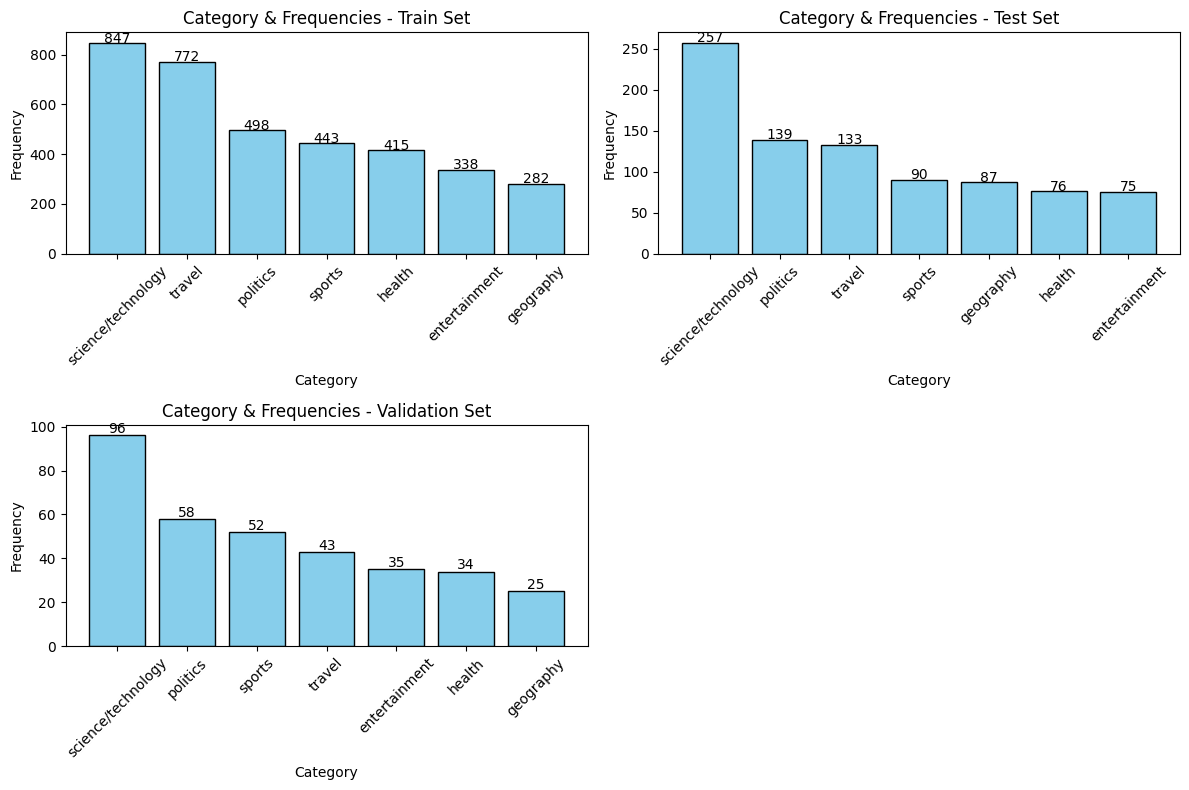

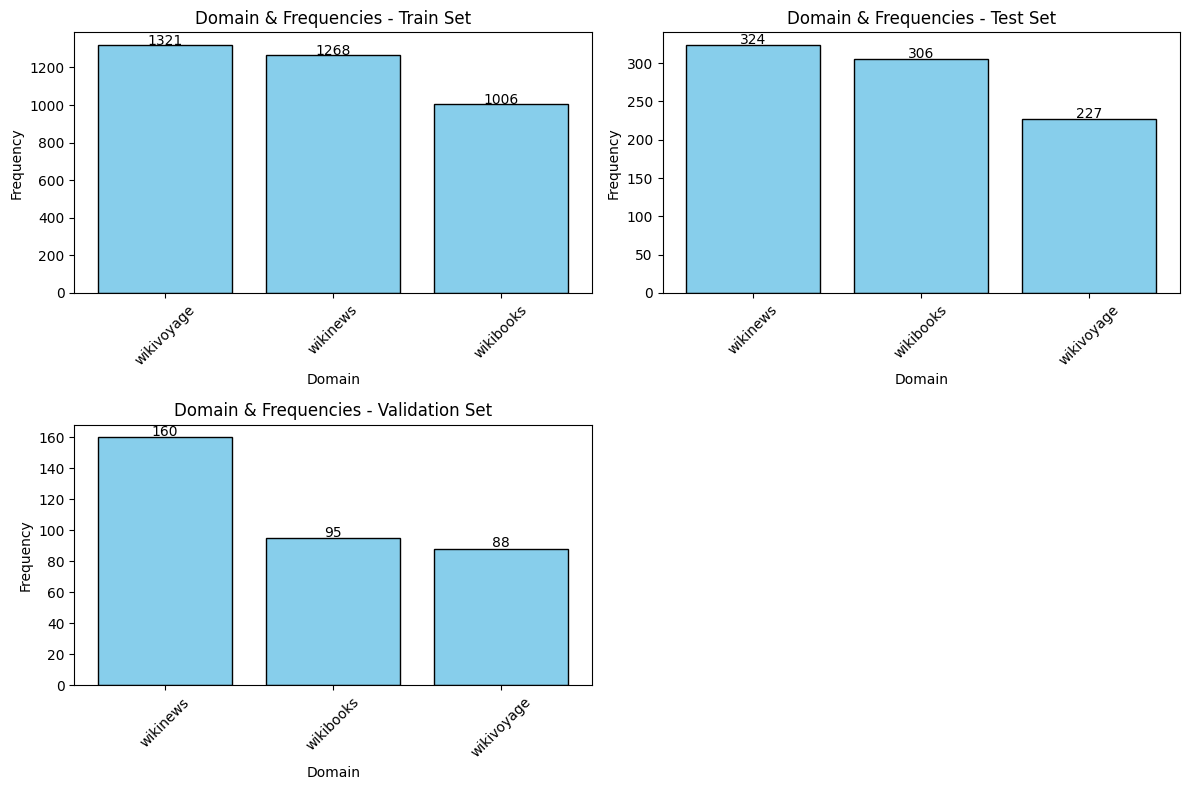

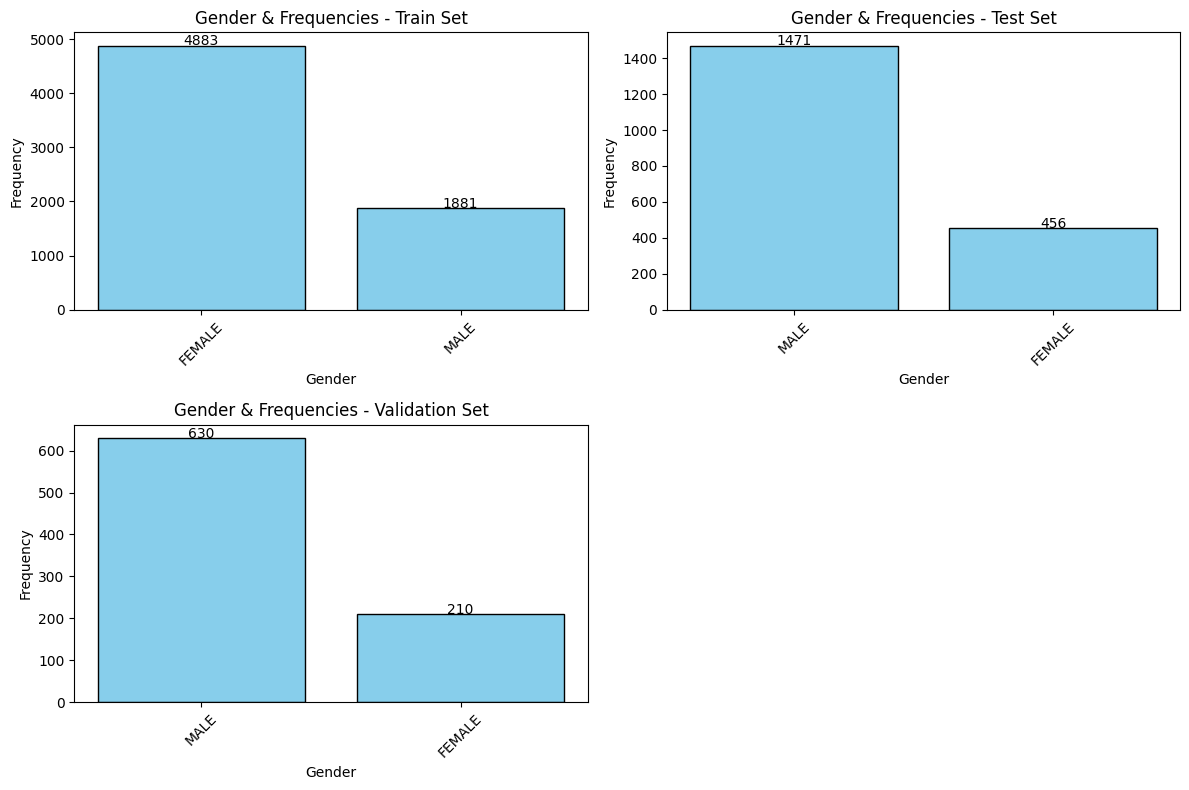

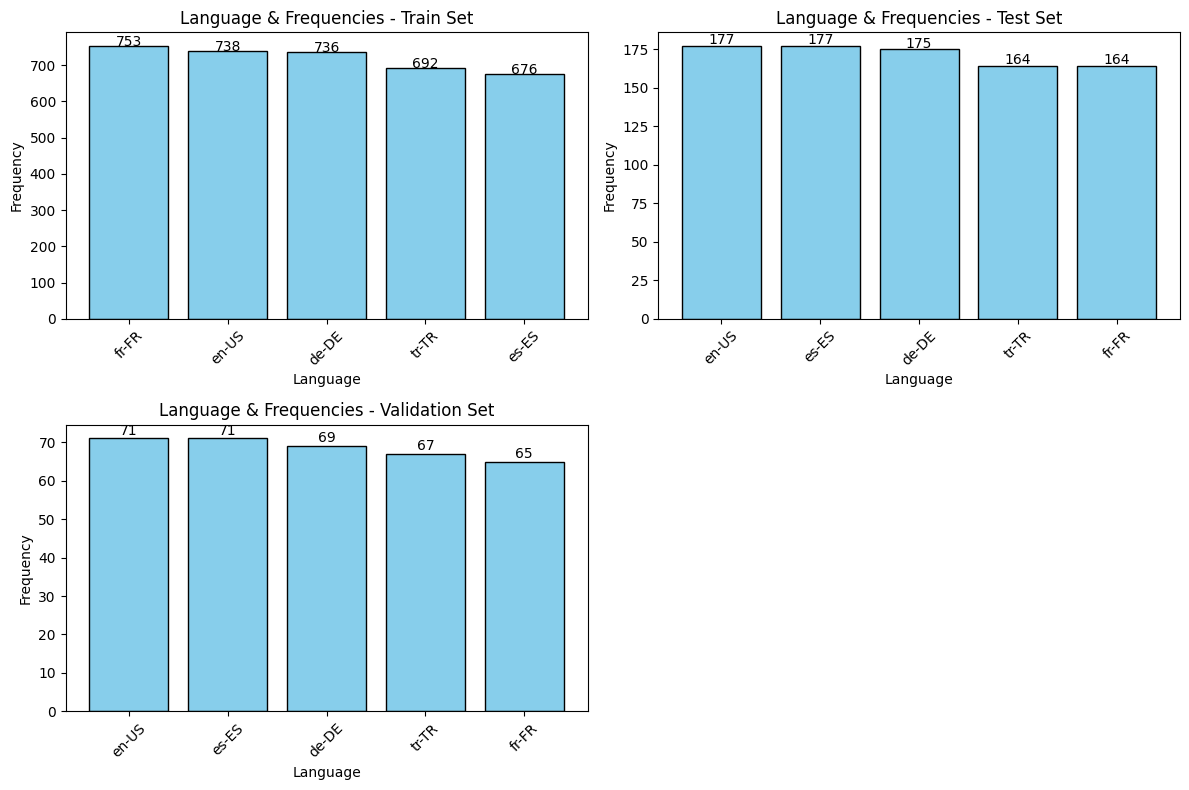

In [12]:
def plot_bar(ax, sorted_data, data_name, split):
    x_vals = list(sorted_data.keys())
    counts = list(sorted_data.values())

    if data_name=="Category":
        x_labels = [category_map[category] for category in x_vals]
        x_positions = range(len(x_vals))
    else:
        x_labels = x_vals
        x_positions = range(len(x_vals))

    # Create bar plot
    ax.bar(x_positions, counts, color='skyblue', edgecolor='black')
    # Set tick positions and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)

    ax.set_xlabel(data_name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"{data_name} & Frequencies - {split} Set")
    
    # Show values on top of bars
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', fontsize=10)

def make_frequency_subgraphs(data=total_categories, data_name: Literal["Category","Domain","Gender","Topic"]="Category"):
    # Sort categories for each dataset
    sorted_train = dict(sorted(data["train"].items(), key=lambda item: item[1], reverse=True))
    sorted_test = dict(sorted(data["test"].items(), key=lambda item: item[1], reverse=True))
    sorted_val = dict(sorted(data["validation"].items(), key=lambda item: item[1], reverse=True))

    # Create a figure with 2x2 subplots
    _, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot each dataset in its respective subplot
    plot_bar(axes[0, 0], sorted_train, data_name, "Train")
    plot_bar(axes[0, 1], sorted_test, data_name, "Test")
    plot_bar(axes[1, 0], sorted_val, data_name, "Validation")

    # Hide the bottom-right subplot 
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

make_frequency_subgraphs(data=total_categories, data_name="Category")
make_frequency_subgraphs(data=total_domains, data_name="Domain")
make_frequency_subgraphs(data=total_genders, data_name="Gender")
make_frequency_subgraphs(data=total_languages, data_name="Language")

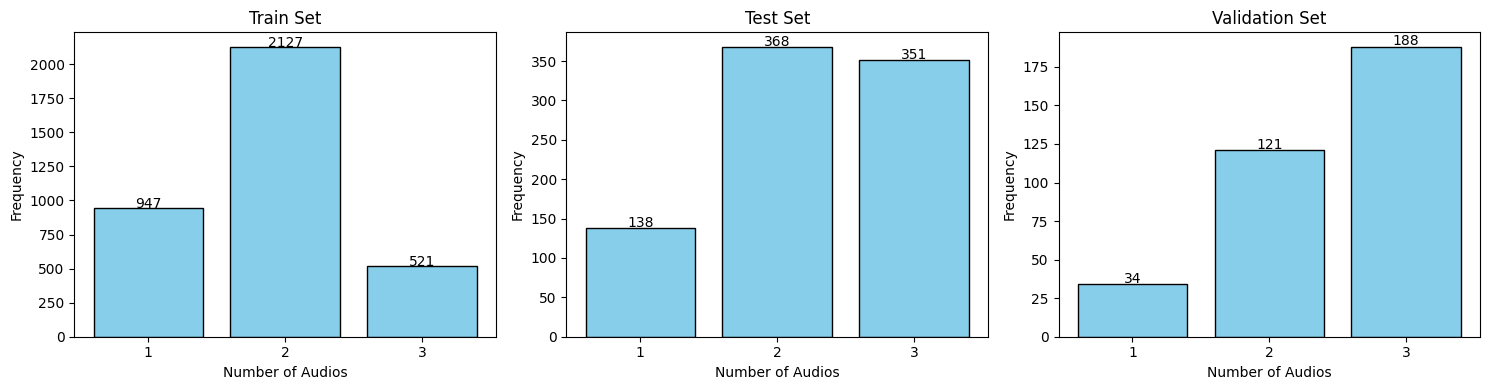

In [13]:
def plot_frequencies(ax, data, title):
    counts = Counter(data)
    vals = list(counts.keys())
    values = counts.values()

    ax.bar(vals, counts.values(), color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Number of Audios")
    ax.set_ylabel("Frequency")
    ax.set_xticks(vals)

    # Show values on top of bars
    for i, v in enumerate(values):
        ax.text(vals[i], v + 1, str(v), ha='center', fontsize=10)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for each dataset split
plot_frequencies(axes[0], num_audios["train"], "Train Set")
plot_frequencies(axes[1], num_audios["test"], "Test Set")
plot_frequencies(axes[2], num_audios["validation"], "Validation Set")

# Adjust layout and show
plt.tight_layout()
plt.show()


# Speech Recognition

In [27]:
def transcribe_audio_google(dataset, temp_wav_path: str):
    audio_trans = []
    for sample_audio in dataset["audio"]:
        # Convert NumPy array to bytes
        audio_array = sample_audio["array"]
        fixed_audio_array = (audio_array * 2147483647).astype(np.int32)  # Scale for int32
        audio_bytes = fixed_audio_array.tobytes()

        # Create an AudioSegment
        audio_segment = AudioSegment(
            data=audio_bytes,
            sample_width=4,
            frame_rate=sample_audio["sampling_rate"],
            channels=1)
        
        # Save as a temporary WAV file (needed for speech recognition)
        audio_segment.export(temp_wav_path, format="wav")

        # Initialize speech recognizer & load the temporary WAV file
        recognizer = sr.Recognizer()
        with sr.AudioFile(temp_wav_path) as source:
            audio_data = recognizer.record(source)

        # Perform speech recognition
        try:
            text = recognizer.recognize_google(audio_data,  language=dataset["language"])
        except sr.UnknownValueError:
            text = "N/A"
            print("Speech recognition could not understand the audio")
        except sr.RequestError:
            text = "N/A"
            print("Could not request results from Google Speech Recognition")

        audio_trans.append(text)
        if os.path.exists(temp_wav_path):
                os.remove(temp_wav_path)
        
    dataset["raw_transc_google"] = audio_trans

    return dataset 

def transcribe_audio_hf(dataset, model: str, provider: str):
    asr_model = pipeline("automatic-speech-recognition", 
                         model=model)
    
    audio_trans = []
    for sample_audio in dataset["audio"]:
        text = asr_model(sample_audio["array"])["text"]
        audio_trans.append(text)

    dataset[f"raw_transc_{provider}"]  = audio_trans
    
    return dataset 

def eval_transc(dataset, transcription: str, original_text: str, provider: str):
    wer = load("wer")

    dataset[f"wer_{provider}"] = wer.compute(predictions=[transcription.lower()], 
                                            references=[original_text.lower()])

    return dataset


def sample_by_language(ds, lang, num_samples):
    return ds.filter(lambda x: (x["language"] == lang) & (len(x["audio"]) == 1)).shuffle().select(range(min(len(ds), num_samples)))

In [30]:
splits = ["train"] # "validation","test",
for split in splits:
    temp_ds = proc_dataset_dict[split]

    languages = list(set(temp_ds["language"]))
    samples_per_lang = 3

    demo_dataset_dict = DatasetDict({lang: sample_by_language(temp_ds, lang, samples_per_lang) for lang in languages})

final_demo_dataset_dict = DatasetDict({lang: [] for lang in languages})
for lang, demo_dataset in demo_dataset_dict.items():
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_google(x, "temp_audio.wav"))
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_hf(x, "facebook/wav2vec2-base-960h", "meta"))
    demo_dataset = demo_dataset.map(lambda x: transcribe_audio_hf(x, "openai/whisper-tiny", "openai"))

    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_google"][0], x["text"], "google"))
    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_meta"][0], x["text"], "meta"))
    demo_dataset = demo_dataset.map(lambda x: eval_transc(x, x["raw_transc_openai"][0], x["text"], "openai"))

    final_demo_dataset_dict[lang] = demo_dataset

output = []
for lang, demo_dataset in final_demo_dataset_dict.items():
    output.append({"language": lang, 
                   "wer_google": np.mean(demo_dataset["wer_google"]),
                   "wer_meta": np.mean(demo_dataset["wer_meta"]),
                   "wer_openai": np.mean(demo_dataset["wer_openai"])})

Map:   0%|          | 0/3 [00:00<?, ? examples/s]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Map:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/ examples]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Map:  67%|██████▋   | 2/3 [00:01<00:00,  1.29 examples/s]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be a

,language,wer_google,wer_meta,wer_openai
0,fr-FR,0.264646,0.958333,0.240909
1,es-ES,0.137016,1.011693,0.296705
2,en-US,0.081732,0.190250,0.068452
3,de-DE,0.309449,0.981481,0.448758
4,tr-TR,0.190327,1.426928,0.555033


In [31]:
pd.DataFrame(output)

,language,wer_google,wer_meta,wer_openai
0,fr-FR,0.264646,0.958333,0.240909
1,es-ES,0.137016,1.011693,0.296705
2,en-US,0.081732,0.190250,0.068452
3,de-DE,0.309449,0.981481,0.448758
4,tr-TR,0.190327,1.426928,0.555033


# Original/Transcribed Text Processing

In [59]:
with open("stop_words_turkish.txt", "r") as f:
    turkish_stopwords_str = f.read()

# Get stopwords for each language
stopwords_dict = {
    'en-US': set(stopwords.words("english")),
    'tr-TR': set(turkish_stopwords_str.split("\n")),
    'fr-FR': set(stopwords.words("french")),
    'es-ES': set(stopwords.words("spanish")),
    'de-DE': set(stopwords.words("german")),
}

# Print sample stopwords from each language
for lang, words in stopwords_dict.items():
    print(f"{lang.capitalize()} Stopwords Sample: {list(words)[:10]}")

En-us Stopwords Sample: ['himself', 'while', 'that', 'with', 'because', 'each', 'hasn', "isn't", 'yourselves', 'ma']
Tr-tr Stopwords Sample: ['kaçı', 'daha', 'indinde', 'dahi', 'bizden', 'evvelden', 'şura', 'göre', 'gayrı', 'öyle']
Fr-fr Stopwords Sample: ['étions', 'sommes', 'avez', 'ma', 'eut', 'avions', 'fus', 'une', 'ton', 'ayantes']
Es-es Stopwords Sample: ['donde', 'están', 'estuviera', 'habidos', 'estáis', 'tengan', 'ni', 'tuvimos', 'haya', 'muchos']
De-de Stopwords Sample: ['zwischen', 'einigen', 'seines', 'sich', 'wo', 'eine', 'anderen', 'die', 'dasselbe', 'alle']


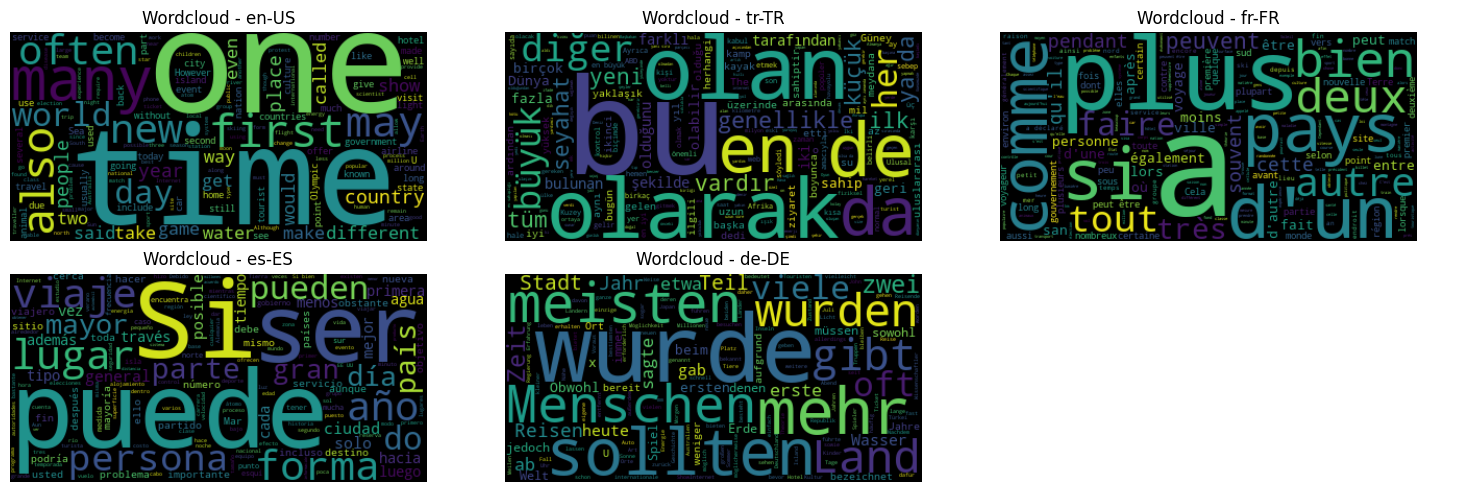

In [60]:
wordclouds = {}
for lang, stopwords_set, in stopwords_dict.items():
    samples = proc_dataset_dict["train"].filter(lambda x: x["language"]==lang)
    full_text = ""
    for sample in samples:
        full_text += sample["text"] + " "

    # Create and generate a word cloud image
    wc = WordCloud(background_color='black', stopwords=stopwords_set).generate(full_text)
    wordclouds[lang] = wc


# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
axes = axes.flatten()
# Plot word clouds
for i, (lang, wc) in enumerate(wordclouds.items()):
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Wordcloud - {lang}")

# Hide the unused 6th subplot
axes[-1].axis("off")
# Adjust layout
plt.tight_layout()
plt.show()

In [105]:
# List of language models
models = {
    'en-US': "en_core_web_md",
    'fr-FR': "fr_core_news_md",
    'de-DE': "de_core_news_md",
    'es-ES': "es_core_news_md"
}

# Load models while dynamically excluding all components except tokenizer & lemmatizer
nlp_models = {}
for lang, model in models.items():
    nlp = spacy.load(model)  # Load model
    allowed_components = {"tok2vec", "lemmatizer", "tokenizer", 'tagger', 'attribute_ruler', 'morphologizer'}
    all_components = set(nlp.pipe_names)
    exclude_components = list(all_components - allowed_components)
    nlp = spacy.load(model, exclude=exclude_components)
    nlp_models[lang] = nlp 


# Create a blank NLP object for Turkish
tr_nlp = spacy.blank("tr")

@Language.component("custom_tokenizer")
def custom_tokenizer(doc):
    # Tokenize the text based on whitespace
    new_tokens = []
    for token in doc:
        new_tokens.append(token.text)
    
    # Return a new Doc with the tokenized words
    return Doc(doc.vocab, words=new_tokens)

@Language.component("custom_lemmatizer")
def custom_lemmatizer(doc):
    tr_analyzer = zeyrek.MorphAnalyzer()
    for token in doc:
        lemmas = tr_analyzer.lemmatize(token.text)[0][1]
        if lemmas == []:
            token.lemma_ = token.text
        else:
            token.lemma_ = lemmas[0]

    return doc

@Language.component("custom_vectorizer")
def custom_vectorizer(doc):
    embedding_model = SentenceTransformer("msbayindir/legal-text-embedding-turkish-v1")
    for token in doc:
        embedding = embedding_model.encode(token.text.lower())
        token._.set("custom_vector", embedding)

    return doc

# Add the custom tokenizer to the pipeline
tr_nlp.add_pipe("custom_tokenizer", first=True)
# Add custom lemmatizer to the pipeline
tr_nlp.add_pipe("custom_lemmatizer", after="custom_tokenizer")
# Add vectorizer to the pipeline
Token.set_extension("custom_vector", default=None, force=True)
tr_nlp.add_pipe("custom_vectorizer", last=True)

# Add turkish nlp object to nlp_models dictionary
nlp_models["tr-TR"] = tr_nlp

In [109]:
text = "Bugünlerde kitapları okuyor ve koşuyor."
doc = nlp_models["tr-TR"](text)
for token in doc:
    if token.is_alpha | token.is_digit:
        print(f"Token: {token.text}, Lemma: {token.lemma_}")
        # print(token._.custom_vector)


APPENDING RESULT: <(bugün_Noun_Time)(-)(bugün:noun_S + ler:a3pl_S + pnon_S + de:loc_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + a3sg_S + ları:p3pl_S + nom_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(Kitap_Noun_Prop)(-)(kitap:nounProper_S + lar:a3pl_S + ı:p3pl_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + a3sg_S + ları:p3pl_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + pnon_S + ı:acc_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + ı:p3sg_S + nom_ST)>
APPENDING RESULT: <(kitap_Noun)(-)(kitap:noun_S + lar:a3pl_S + ı:p3pl_S + nom_ST)>
APPENDING RESULT: <(okumak_Verb)(-)(ok:verbRoot_VowelDrop_S + uyor:vProgYor_S + vA3sg_ST)>
APPENDING RESULT: <(ve_Conj)(-)(ve:conjRoot_ST)>
APPENDING RESULT: <(koşmak_Verb)(-)(koş:verbRoot_S + uyor:vProgYo

Token: Bugünlerde, Lemma: bugün
Token: kitapları, Lemma: Kitap
Token: okuyor, Lemma: okumak
Token: ve, Lemma: ve
Token: koşuyor, Lemma: koşmak


In [108]:
text = "Nowadays he read books and runs."
doc = nlp_models["en-US"](text)
for token in doc:
    if token.is_alpha | token.is_digit:
        print(f"Token: {token.text}, Lemma: {token.lemma_}")
        # print(token.vector)


Token: Nowadays | Lemma: nowadays
Token: he | Lemma: he
Token: read | Lemma: read
Token: books | Lemma: book
Token: and | Lemma: and
Token: runs | Lemma: run
